# MUY
# IMPORTANTE
# LEER

#### ESTE NOTEBOOK CONSUME MUCHISIMA MEMORIA, EJECUTAR EL PRIMER MODELO OCUPA APROXIMADAMENTE 10 GIGAS. NO PROBE MAS DE UNO, PERO SEGURO QUE CONSUME MAS QUE 16. OJO

# Voting

En este Notebook pondremos a prueba la potencia de este ensamble para predecir si la instancia tiene alto poder adquisitivo.

Estaremos trabajando sobre los mejores modelos entrenados en los notebooks anteriores para ver con qué nos encontramos si trabajan en conjunto.



In [2]:
# Modelo 
from sklearn.ensemble import VotingClassifier

# Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from preprocessing import preprocessing_base_parte_1

# Otros
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import utils


# Métricas
from sklearn.metrics import plot_roc_curve, roc_auc_score, classification_report, plot_confusion_matrix

In [3]:
df = utils.get_data()

## Modelo 1 - Preprocessing base

Utilizaremos para este primer modelo a todos los modelos (cuyas métricas son decentes) entrenados con el preprocessing base, estos serán:

* DecisionTreeClassifier
* KNeighborsClassifier
* SVC
* RandomForest
* BaggingClassifier
* AdaBoost

Veamos qué pasa!

In [4]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, Y, random_state=112)

X_train_1, X_test_1 = preprocessing_base_parte_1(X_train_1, X_test_1)

In [5]:
m1_dtc = DecisionTreeClassifier(criterion='gini', min_samples_leaf=50, max_depth=11)
m1_knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=30, p=1, weights='uniform')
m1_svm = SVC(C=100.0, gamma=0.0001, probability=True)
m1_rfc = RandomForestClassifier(n_estimators=5001, criterion='entropy', max_features=2, n_jobs=-1, random_state=27)
m1_bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators = 501, n_jobs=-1, random_state=27)
m1_abc = AdaBoostClassifier(algorithm='SAMME.R', learning_rate=1.25, n_estimators = 901, random_state = 27)

m1 = VotingClassifier(estimators=[('dtc', m1_dtc),
                                  ('knn', m1_knn),
                                  ('svm', m1_svm),
                                  ('rfc', m1_rfc),
                                  ('bag', m1_bag),
                                  ('abc', m1_abc)],
                      voting='soft', n_jobs=-1, verbose=4)

In [6]:
m1.fit(X_train_1, y_train_1)

VotingClassifier(estimators=[('dtc',
                              DecisionTreeClassifier(max_depth=11,
                                                     min_samples_leaf=50)),
                             ('knn',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   n_neighbors=30, p=1)),
                             ('svm',
                              SVC(C=100.0, gamma=0.0001, probability=True)),
                             ('rfc',
                              RandomForestClassifier(criterion='entropy',
                                                     max_features=2,
                                                     n_estimators=5001,
                                                     n_jobs=-1,
                                                     random_state=27)),
                             ('bag',
                              BaggingClassifier(base_estimator=DecisionTreeClassifier(),
         

In [7]:
print(classification_report(y_test_1,m1.predict(X_test_1), digits=4))

              precision    recall  f1-score   support

           0     0.8725    0.9499    0.9095      6182
           1     0.7803    0.5620    0.6534      1959

    accuracy                         0.8565      8141
   macro avg     0.8264    0.7559    0.7815      8141
weighted avg     0.8503    0.8565    0.8479      8141



Vemos que el modelo está lejos de ser lo esperado, sin embargo se trata de un modelo con un accuracy de 85.7%, número interesante.

Los demás valores son los usuales, poco recall para unos, muchos recalls para unos. La precision es relativamente alta.

Veamos la matriz de confusión.

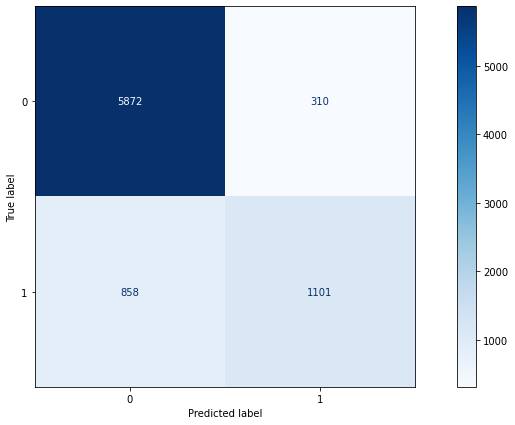

In [8]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(m1, X_test_1, y_test_1, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

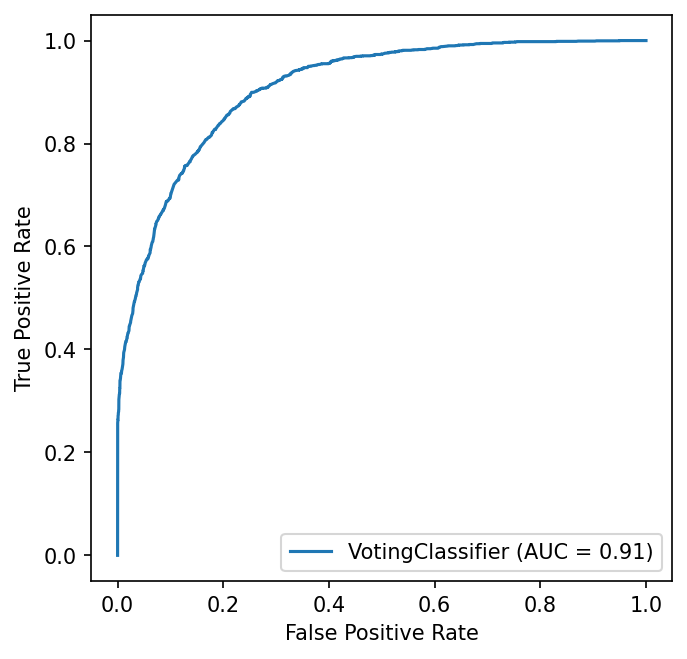

In [9]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
plot_roc_curve(m1, X_test_1, y_test_1, ax=ax)
plt.show()

In [11]:
roc_auc_score(y_test_1, m1.predict_proba(X_test_1)[:, 1])

0.9089770413172396

Vemos que se obtiene un valor de RocAUC bastante alto (si bien, aún así no es más alto que el más alto de los modelos)

## Modelo 2 - Preprocessing Significantes